In [147]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

import itertools
from itertools import product

import networkx as nx
import pandas as pd
import numpy as np

from pgmpy.models import BayesianModel
from pgmpy.inference import BeliefPropagation
from pgmpy.inference import VariableElimination

In [45]:
data = pd.read_csv('heart.csv')
data = data.drop('slope', axis=1)
data = data.drop('age', axis=1)
data = data.drop('sex', axis=1)

### Full Dataset

In [46]:
data

,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,thal,target
0,3,145,233,1,0,150,0,2.3,0,1,1
1,2,130,250,0,1,187,0,3.5,0,2,1
2,1,130,204,0,0,172,0,1.4,0,2,1
3,1,120,236,0,1,178,0,0.8,0,2,1
4,0,120,354,0,1,163,1,0.6,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
298,0,140,241,0,1,123,1,0.2,0,3,0
299,3,110,264,0,1,132,0,1.2,0,3,0
300,0,144,193,1,1,141,0,3.4,2,3,0
301,0,130,131,0,1,115,1,1.2,1,3,0


In [177]:
# Function to plot network using matplotlib plt. Size is argument - takes in belief/markov networks
def display(graph, size=4):
    pos = nx.circular_layout(graph)
    plt.figure(3,figsize=(4,4)) 
    nx.draw(graph, pos, with_labels=True)
    plt.show()

In [178]:
# Takes in belief networks and emits graph skeleton
def graph_skeleton(bn):
    gs = nx.Graph()
    gs.add_nodes_from(bn.nodes())
    gs.add_edges_from(bn.edges())
        
    return gs

In [179]:
# Moralizes graph - connects all unconnected parents of any child
def moralize(bn):
    def get_parents(node):
        return [x[0] for x in bn.in_edges(node)]
    
    nodes = bn.nodes()
    mn = nx.Graph()
    mn.add_nodes_from(nodes)
    
    for node in nodes:
        parents = get_parents(node)
#         print(node, parents)
        
        for par in parents:
            mn.add_edge(node, par)
            
        for par_pair in itertools.combinations(parents, 2):
            if not mn.has_edge(par_pair[0], par_pair[1]):
                mn.add_edge(par_pair[0], par_pair[1])
        
    return mn

In [180]:
# Gets the factor table of variable elimination variable in 2D list format. See below - This is usually printed directly as a string, I wrote a function from the source code to get the values for printing
def get_factortable(df):
    print_state_names = False
    value_index = 0
    factor_table = []
    for prob in product(*[range(card) for card in df.cardinality]):
        if df.state_names and print_state_names:
            prob_list = [
                "{var}({state})".format(
                    var=list(df.variables)[i],
                    state=df.state_names[list(df.variables)[i]][prob[i]],
                )
                for i in range(len(df.variables))
            ]
        else:
            prob_list = [
                prob[i]
#                 f"{list(df.variables)[i]}_{prob[i]}"
                for i in range(len(df.variables))
            ]

        prob_list.append(df.values.ravel()[value_index])
        factor_table.append(prob_list)
        value_index += 1
        
    return factor_table

In [181]:
# Plots factor table with 2 input variables - and 1 output (representing probability) in a 3d plot
def plot_2vars(ft):
    x = [f[0] for f in ft]
    y = [f[1] for f in ft]
    z = [f[2] for f in ft]    
    xs, ys = np.array(x), np.array(y)
    zs = np.array(z)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xs, ys, zs)
    plt.show()

In [182]:
# Plots factor table with 3 input variables - and 1 output (representing probability) in a 3d plot
def plot_3vars(ft):
    x = [f[0] for f in ft]
    y = [f[1] for f in ft]
    z = [f[2] for f in ft]
    c = [f[3] for f in ft]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

### Working Code on Sample data

#### Subset of graph

In [95]:
feat_graph_heart = {'cp': [], 'trestbps': ['chol', 'fbs'], 'chol': ['fbs'], 'fbs': [], 'restecg': ['chol', 'fbs'], 'target': ['cp', 'trestbps', 'chol', 'restecg']}

#### Belief network of that graph

In [96]:
bn_heart = nx.DiGraph()
bn_heart.add_nodes_from(feat_graph_heart.keys())

for k, v in feat_graph_heart.items():
    bn_heart.add_edges_from(([(t, k) for t in v]))

#### Bayesian model of belief network

In [183]:
bn_heart_model = BayesianModel(bn_heart.edges())

#### Data subset corresponding to graph subset

In [98]:
data_heart = data[['cp', 'trestbps', 'chol', 'fbs', 'restecg', 'target']]

In [119]:
data_heart

,cp,trestbps,chol,fbs,restecg,target
0,3,145,233,1,0,1
1,2,130,250,0,1,1
2,1,130,204,0,0,1
3,1,120,236,0,1,1
4,0,120,354,0,1,1
...,...,...,...,...,...,...
298,0,140,241,0,1,0
299,3,110,264,0,1,0
300,0,144,193,1,1,0
301,0,130,131,0,1,0


In [99]:
dheart_sample = data_heart.sample(frac=0.03)

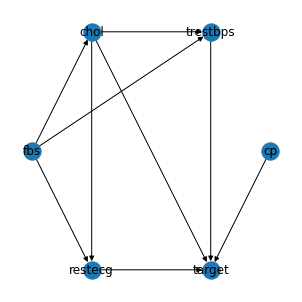

In [187]:
# Displays belief network
display(bn_heart)

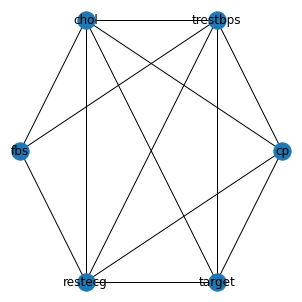

In [188]:
# Displays Markov Network
mn_heart = moralize(bn_heart)
display(mn_heart)

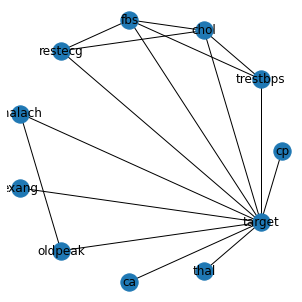

In [189]:
# Displays graph skeleton
bn_heart_skeleton = graph_skeleton(bn_heart)
display(bn_skeleton)

In [190]:
# Fits data into bayesian model
bn_heart_model.fit(dheart_sample)

In [104]:
# Creates junction tree
jt_heart = BeliefPropagation(bn_heart_model)

In [105]:
jt_heart.calibrate()

/home/nikhil/miniconda3/envs/pgm/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:775: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi1.values


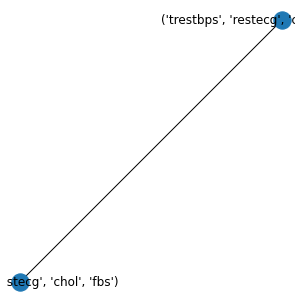

In [106]:
display(jt_heart.junction_tree)

In [108]:
# Cliques of JT represented in graph
jt_heart.get_cliques()

NodeView((('trestbps', 'restecg', 'chol', 'cp', 'target'), ('trestbps', 'restecg', 'chol', 'fbs')))

### Not as useful or necessary for our project - But plots max marginals (probability of argmax variable) over a marginal dist

In [115]:
inf_heart = VariableElimination(bn_heart_model)

In [116]:
inf_heart.max_marginal(['cp'])

Finding Elimination Order: : 100%|██████████| 5/5 [00:00<00:00, 265.88it/s]

Eliminating: fbs: 100%|██████████| 5/5 [00:00<00:00, 39.63it/s]     


0.4444444444444444

In [117]:
inf_heart.max_marginal(variables=['chol', 'restecg'])

Eliminating: fbs: 100%|██████████| 4/4 [00:00<00:00, 68.00it/s]


0.13793103448275862

## Marginals we need

In [204]:
# Marginal with fixed value of evidence variable
print(jt_heart.query(['target'], evidence={'trestbps': 135}))

Eliminating: chol: 100%|██████████| 4/4 [00:00<00:00, 127.03it/s]

+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.2778 |
+-----------+---------------+
| target(1) |        0.7222 |
+-----------+---------------+


In [201]:
# Marginal dist - plotting joint distribution over 2 variables
tc = jt_heart.query(['trestbps', 'chol'])
print(tc)

Eliminating: target: 100%|██████████| 4/4 [00:00<00:00, 37.05it/s]

+---------------+-----------+----------------------+
| trestbps      | chol      |   phi(trestbps,chol) |
+===============+===========+======================+
| trestbps(105) | chol(149) |               0.0000 |
+---------------+-----------+----------------------+
| trestbps(105) | chol(157) |               0.0000 |
+---------------+-----------+----------------------+
| trestbps(105) | chol(198) |               0.1111 |
+---------------+-----------+----------------------+
| trestbps(105) | chol(203) |               0.0000 |
+---------------+-----------+----------------------+
| trestbps(105) | chol(226) |               0.0000 |
+---------------+-----------+----------------------+
| trestbps(105) | chol(236) |               0.0000 |
+---------------+-----------+----------------------+
| trestbps(105) | chol(270) |               0.0000 |
+---------------+-----------+----------------------+
| trestbps(105) | chol(278) |               0.0000 |
+---------------+-----------+-----------------

In [202]:
# Marginal dist - plotting joint distribution over 3 variables
cct = jt_heart.query(['trestbps', 'chol', 'target'])
print(cct)

Eliminating: fbs: 100%|██████████| 3/3 [00:00<00:00, 34.32it/s]

+---------------+-----------+-----------+-----------------------------+
| trestbps      | chol      | target    |   phi(trestbps,chol,target) |
+===============+===========+===========+=============================+
| trestbps(105) | chol(149) | target(0) |                      0.0000 |
+---------------+-----------+-----------+-----------------------------+
| trestbps(105) | chol(149) | target(1) |                      0.0000 |
+---------------+-----------+-----------+-----------------------------+
| trestbps(105) | chol(157) | target(0) |                      0.0000 |
+---------------+-----------+-----------+-----------------------------+
| trestbps(105) | chol(157) | target(1) |                      0.0000 |
+---------------+-----------+-----------+-----------------------------+
| trestbps(105) | chol(198) | target(0) |                      0.0309 |
+---------------+-----------+-----------+-----------------------------+
| trestbps(105) | chol(198) | target(1) |                      0

In [203]:
# Marginal dist - not joint, 3 separate distributions
cct2 = jt_heart.query(['cp', 'chol', 'target'], joint=False)
print(cct2)
print(cct2['cp'])

Eliminating: fbs: 100%|██████████| 3/3 [00:00<00:00, 68.20it/s]

{'cp': <DiscreteFactor representing phi(cp:4) at 0x7f7ce5ce0940>, 'chol': <DiscreteFactor representing phi(chol:9) at 0x7f7ce5ce0be0>, 'target': <DiscreteFactor representing phi(target:2) at 0x7f7ce5ce0dd8>}
+-------+-----------+
| cp    |   phi(cp) |
+=======+===========+
| cp(0) |    0.3333 |
+-------+-----------+
| cp(1) |    0.4444 |
+-------+-----------+
| cp(2) |    0.1111 |
+-------+-----------+
| cp(3) |    0.1111 |
+-------+-----------+


### Factortables that were being printed as strings extracted into array

In [146]:
cc_ft = get_factortable(cc)
cc_ft

[[0, 0, 0.0],
 [0, 1, 0.0],
 [0, 2, 0.1111111111111111],
 [0, 3, 0.0],
 [0, 4, 0.0],
 [0, 5, 0.0],
 [0, 6, 0.0],
 [0, 7, 0.0],
 [0, 8, 0.0],
 [1, 0, 0.1111111111111111],
 [1, 1, 0.0],
 [1, 2, 0.0],
 [1, 3, 0.0],
 [1, 4, 0.0],
 [1, 5, 0.0],
 [1, 6, 0.0],
 [1, 7, 0.0],
 [1, 8, 0.0],
 [2, 0, 0.0],
 [2, 1, 0.1111111111111111],
 [2, 2, 0.0],
 [2, 3, 0.0],
 [2, 4, 0.0],
 [2, 5, 0.1111111111111111],
 [2, 6, 0.0],
 [2, 7, 0.0],
 [2, 8, 0.0],
 [3, 0, 0.0],
 [3, 1, 0.0],
 [3, 2, 0.0],
 [3, 3, 0.1111111111111111],
 [3, 4, 0.0],
 [3, 5, 0.0],
 [3, 6, 0.0],
 [3, 7, 0.0],
 [3, 8, 0.0],
 [4, 0, 0.0],
 [4, 1, 0.0],
 [4, 2, 0.0],
 [4, 3, 0.0],
 [4, 4, 0.0],
 [4, 5, 0.0],
 [4, 6, 0.0],
 [4, 7, 0.0],
 [4, 8, 0.1111111111111111],
 [5, 0, 0.0],
 [5, 1, 0.0],
 [5, 2, 0.0],
 [5, 3, 0.0],
 [5, 4, 0.1111111111111111],
 [5, 5, 0.0],
 [5, 6, 0.0],
 [5, 7, 0.0],
 [5, 8, 0.0],
 [6, 0, 0.0],
 [6, 1, 0.0],
 [6, 2, 0.0],
 [6, 3, 0.0],
 [6, 4, 0.0],
 [6, 5, 0.0],
 [6, 6, 0.0],
 [6, 7, 0.11111111111111109],
 [6, 8, 0.0

In [143]:
cct_ft = get_factortable(cct)
cct_ft

[[0, 0, 0, 0.0],
 [0, 0, 1, 0.0],
 [0, 1, 0, 0.0],
 [0, 1, 1, 0.0],
 [0, 2, 0, 0.030864197530864196],
 [0, 2, 1, 0.08024691358024691],
 [0, 3, 0, 0.0],
 [0, 3, 1, 0.0],
 [0, 4, 0, 0.0],
 [0, 4, 1, 0.0],
 [0, 5, 0, 0.0],
 [0, 5, 1, 0.0],
 [0, 6, 0, 0.0],
 [0, 6, 1, 0.0],
 [0, 7, 0, 0.0],
 [0, 7, 1, 0.0],
 [0, 8, 0, 0.0],
 [0, 8, 1, 0.0],
 [1, 0, 0, 0.03703703703703704],
 [1, 0, 1, 0.07407407407407408],
 [1, 1, 0, 0.0],
 [1, 1, 1, 0.0],
 [1, 2, 0, 0.0],
 [1, 2, 1, 0.0],
 [1, 3, 0, 0.0],
 [1, 3, 1, 0.0],
 [1, 4, 0, 0.0],
 [1, 4, 1, 0.0],
 [1, 5, 0, 0.0],
 [1, 5, 1, 0.0],
 [1, 6, 0, 0.0],
 [1, 6, 1, 0.0],
 [1, 7, 0, 0.0],
 [1, 7, 1, 0.0],
 [1, 8, 0, 0.0],
 [1, 8, 1, 0.0],
 [2, 0, 0, 0.0],
 [2, 0, 1, 0.0],
 [2, 1, 0, 0.030864197530864196],
 [2, 1, 1, 0.08024691358024691],
 [2, 2, 0, 0.0],
 [2, 2, 1, 0.0],
 [2, 3, 0, 0.0],
 [2, 3, 1, 0.0],
 [2, 4, 0, 0.0],
 [2, 4, 1, 0.0],
 [2, 5, 0, 0.030864197530864196],
 [2, 5, 1, 0.08024691358024691],
 [2, 6, 0, 0.0],
 [2, 6, 1, 0.0],
 [2, 7, 0, 0.0],
 [

### Plotting factor tables into 3d plots for 2 and 3 variables

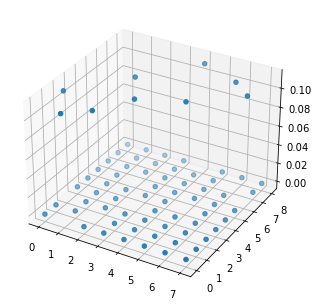

In [166]:
plot_2vars(cc_ft)

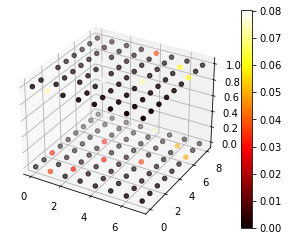

In [149]:
plot_3vars(cct_ft)

## Repeat the same with larger graph and more rows of data 

### Starter Code

In [167]:
feat_graph = {'cp': [], 'trestbps': ['chol', 'fbs'], 'chol': ['fbs'], 'fbs': [], 'restecg': ['chol', 'fbs'], 'thalach': [], 'exang': [], 'oldpeak': ['thalach'], 'ca': [], 'thal': [], 'target': ['cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']}

In [168]:
bn = nx.DiGraph()
bn.add_nodes_from(feat_graph.keys())

for k, v in feat_graph.items():
    bn.add_edges_from(([(t, k) for t in v]))

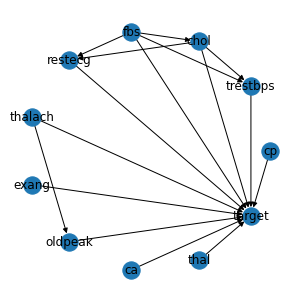

In [169]:
display(bn)

In [173]:
data_sample = data.sample(frac=0.3)
data_sample

,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,thal,target
39,2,160,360,0,0,151,0,0.8,0,2,1
197,0,125,254,1,1,163,0,0.2,2,3,0
193,0,145,282,0,0,142,1,2.8,2,3,0
218,0,135,254,0,0,127,0,2.8,1,3,0
87,1,101,197,1,1,156,0,0.0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...
50,2,130,256,0,0,149,0,0.5,0,2,1
142,2,120,209,0,1,173,0,0.0,0,2,1
298,0,140,241,0,1,123,1,0.2,0,3,0
251,0,132,247,1,0,143,1,0.1,4,3,0


In [174]:
bn_model = BayesianModel(bn.edges())

In [175]:
# bn_model.fit(data_sample)
# jt = BeliefPropagation(bn_model)
# jt.calibrate()
# display(jt.junction_tree)